# Parallelism Demo

Consider a function, $f$,

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$

<img src='images/fourier.jpeg' width=150 style="display:block;margin-left:auto;margin-right:auto;width:50%;"/>

> All vibes may be approximated by harmonic oscillators

In [1]:
import sys
sys.path.append('../common')
from plt_style import *
import numpy as np
import pylab as plt
import scipy as sp
import os
def set_threads(threads):
  os.environ['MKL_NUM_THREADS'] = str(threads)
  os.environ['OMP_NUM_THREADS'] = str(threads)
  return None


In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              48
On-line CPU(s) list: 0-47
Thread(s) per core:  1
Core(s) per socket:  24
Socket(s):           2
NUMA node(s):        8
Vendor ID:           AuthenticAMD
CPU family:          25
Model:               1
Model name:          AMD EPYC 7413 24-Core Processor
Stepping:            1
CPU MHz:             2644.976
BogoMIPS:            5289.95
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            32768K
NUMA node0 CPU(s):   0-5
NUMA node1 CPU(s):   6-11
NUMA node2 CPU(s):   12-17
NUMA node3 CPU(s):   18-23
NUMA node4 CPU(s):   24-29
NUMA node5 CPU(s):   30-35
NUMA node6 CPU(s):   36-41
NUMA node7 CPU(s):   42-47
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nons

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          503Gi       7.9Gi       357Gi       147Mi       137Gi       490Gi
Swap:         4.0Gi       203Mi       3.8Gi


In [4]:
N = 2**20+1
t = np.linspace(0,10*np.pi,N)[:-1]
f = np.array([ (-1)**k*np.sin(ell*t)/ell**2 for k,ell in enumerate(2*np.arange(31)+1) ]).sum(axis=0)

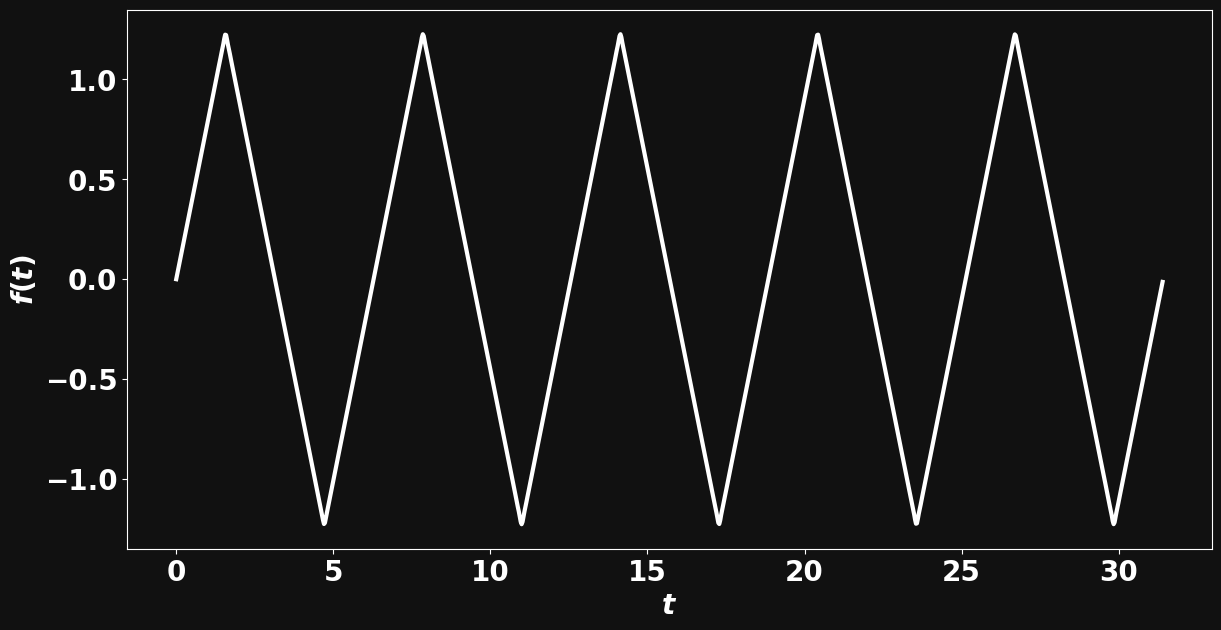

In [5]:
skip  = 1000
ts,fs= [ u[::skip] for u in [t,f] ]
plt.figure(figsize=(14,7))
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')

In [6]:
%%time
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 21.4 ms, sys: 5.64 ms, total: 27 ms
Wall time: 26.6 ms


In [7]:
%%time
set_threads(2)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 24.2 ms, sys: 1.82 ms, total: 26 ms
Wall time: 25.6 ms


In [8]:
%%time
set_threads(4)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 25.6 ms, sys: 1.25 ms, total: 26.8 ms
Wall time: 26.3 ms


In [9]:
%%time
set_threads(8)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 24.2 ms, sys: 2.28 ms, total: 26.5 ms
Wall time: 26.1 ms


In [10]:
%%time
set_threads(16)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 24.3 ms, sys: 2.39 ms, total: 26.7 ms
Wall time: 26.2 ms


In [11]:
%%time
set_threads(32)
q = abs(np.fft.fft(f)[:len(t)//2])

CPU times: user 25.2 ms, sys: 1.26 ms, total: 26.4 ms
Wall time: 25.9 ms


In [12]:
!uptime

 10:42:07 up 42 days,  1:07, 11 users,  load average: 0.04, 0.20, 0.18


In [13]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.arange(len(q))
p   = q/q.max()
k   = np.linspace(1,11,1001)

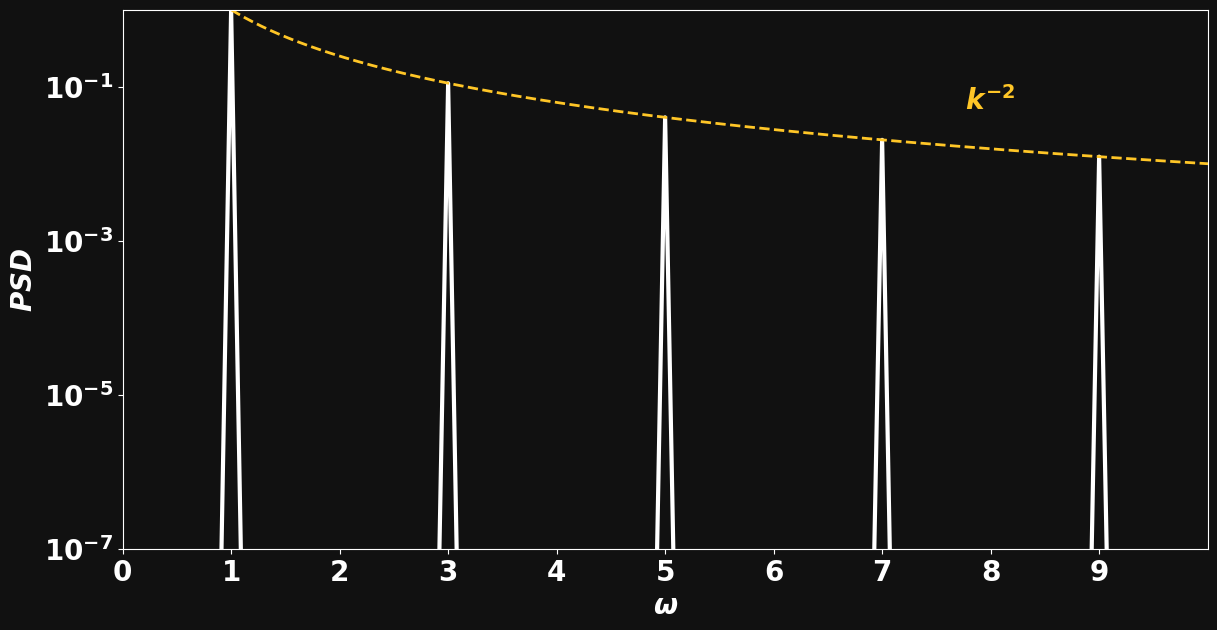

In [14]:
plt.figure(figsize=(14,7))
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.arange(10),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum On the CPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [15]:
import cheb

In [16]:
N = 256
Do,xo = cheb.cheb(N)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")

Sanity: True


In [17]:
X,Y,Z = np.meshgrid(x,x,x,indexing='ij')
U = np.array([ np.cos(ell*X)*np.sin(ell*Z)/ell**3 for ell in 2*np.arange(31)+1 ]).sum(axis=0)

In [23]:
set_threads(48)

In [24]:
%%time
dUdx = np.einsum('ij,jkl->ikl',D,U)

CPU times: user 1.39 s, sys: 114 ms, total: 1.5 s
Wall time: 1.37 s


In [25]:
dUdx_iter = 0*dUdx

In [26]:
%%time
for k in range(U.shape[-1]):
    dUdx_iter[:,:,k] = D @ U[:,:,k]

CPU times: user 4.56 s, sys: 0 ns, total: 4.56 s
Wall time: 4.57 s


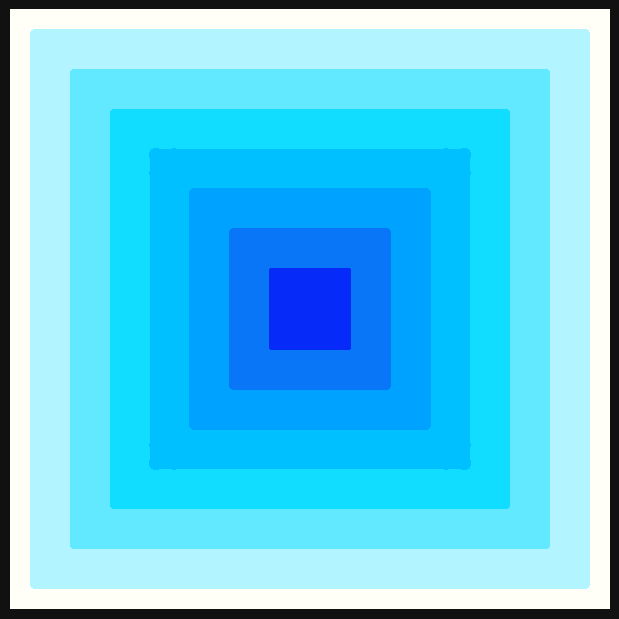

In [27]:
f,a = no_ax_fax()
L   = np.abs(dUdx).max() * np.linspace(-1,1,16)
plt.contourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=mycm15,linewidths=None)